In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

#import requests


matches = pd.read_csv("matches.csv", index_col = 0)
# Drop the third column

column_to_drop = matches.columns[2] # This gets the label of the 3rd column
matches = matches.drop(column_to_drop, axis=1) #dropping the useless columns,
matches["date"] = pd.to_datetime(matches["date"])
matches["venue_code"] = matches["venue"].astype("category").cat.codes #Home 1,Away 0

matches["opp_code"] = matches["opponent"].astype("category").cat.codes # Code for each team
matches["hour"] = matches["time"].str.replace(":.+", "", regex = True).astype("int")

matches["day_code"] = matches["date"].dt.dayofweek # Number for each day -> Monday = 0 , Tuesday = 1 ...
matches["target"] = ( matches["result"] == "W").astype("int") # 0 = loss/draw ... 1 = won


matches.head()


,date,time,round,day,venue,result,gf,ga,opponent,xg,...,fk,pk,pkatt,season,team,venue_code,opp_code,hour,day_code,target
1,2021-08-15,16:30,Matchweek 1,Sun,Away,L,0.0,1.0,Tottenham,1.9,...,1.0,0.0,0.0,2022,Manchester City,0,18,16,6,0
2,2021-08-21,15:00,Matchweek 2,Sat,Home,W,5.0,0.0,Norwich City,2.7,...,1.0,0.0,0.0,2022,Manchester City,1,15,15,5,1
3,2021-08-28,12:30,Matchweek 3,Sat,Home,W,5.0,0.0,Arsenal,3.8,...,0.0,0.0,0.0,2022,Manchester City,1,0,12,5,1
4,2021-09-11,15:00,Matchweek 4,Sat,Away,W,1.0,0.0,Leicester City,2.9,...,0.0,0.0,0.0,2022,Manchester City,0,10,15,5,1
6,2021-09-18,15:00,Matchweek 5,Sat,Home,D,0.0,0.0,Southampton,1.1,...,1.0,0.0,0.0,2022,Manchester City,1,17,15,5,0


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, mean_squared_error


# Train RandomForest with entropy
rf_entropy = RandomForestClassifier(n_estimators = 50, min_samples_split = 10, criterion = 'entropy', random_state=1)

# Define the predictors and split the data
predictors = ["venue_code", "opp_code", "hour", "day_code"]
data_before_2022 = matches[matches["date"] <='2021-12-31' ]
train, validation = train_test_split(data_before_2022, test_size=0.2, random_state=100) # 80% training, 20% validation
test = matches[matches["date"] >'2022-01-01' ] # no games on a new years day

rf_entropy.fit(train[predictors], train["target"])
val_preds_entropy = rf_entropy.predict(validation[predictors])
val_acc_entropy = accuracy_score(validation["target"], val_preds_entropy)
print(f"Validation Accuracy using Entropy: {val_acc_entropy:.2f}")

# You can also test on the test set if needed
test_preds_entropy = rf_entropy.predict(test[predictors])
test_acc_entropy = accuracy_score(test["target"], test_preds_entropy)
print(f"Test Accuracy using Entropy: {test_acc_entropy:.2f}")
precision_rf_entropy = precision_score(test["target"], test_preds_entropy)




Validation Accuracy using Entropy: 0.64
Test Accuracy using Entropy: 0.57


In [3]:
combined = pd.DataFrame(dict(actual = test["target"], prediction = test_preds_entropy))
pd.crosstab(index = combined["actual"], columns = combined["prediction"]) 
# when we predicted win (most of the time we were wrong 

prediction,0,1
actual,,
0,135,37
1,81,23


In [4]:
from sklearn.metrics import precision_score

precision_score(test["target"], test_preds_entropy) # CheckPoint 
# when we predicted W, team only won 38% of the time  

0.38333333333333336

In [5]:
grouped_matches = matches.groupby("team")
group = grouped_matches.get_group("Liverpool")


In [6]:
#improve precision with rolling_averages
def rolling_averages(group, cols, new_cols):
    group = group.sort_values("date") # checking teams recent perfomance
    rolling_stats = group[cols].rolling(3, closed ='left').mean() 
    # closed = 'left' prevents it getting knowledge from the future
    group[new_cols] = rolling_stats
    group = group.dropna(subset = new_cols) # removes all the rows that have missing values
    return group 




In [7]:

cols = ["gf", "ga", "sh", "sot","dist", "fk", "pk", "pkatt"]

new_cols = []
for i in cols:
    new_cols.append(f"{i}_rolling")
new_cols

['gf_rolling',
 'ga_rolling',
 'sh_rolling',
 'sot_rolling',
 'dist_rolling',
 'fk_rolling',
 'pk_rolling',
 'pkatt_rolling']

In [8]:
rolling_averages(group, cols, new_cols).head()
matches_rolling = matches.groupby("team").apply(lambda x:rolling_averages(x,cols, new_cols))
matches_rolling = matches_rolling.droplevel('team')
matches_rolling.index = range(matches_rolling.shape[0])
matches_rolling.head()

,date,time,round,day,venue,result,gf,ga,opponent,xg,...,day_code,target,gf_rolling,ga_rolling,sh_rolling,sot_rolling,dist_rolling,fk_rolling,pk_rolling,pkatt_rolling
0,2020-10-04,14:00,Matchweek 4,Sun,Home,W,2.0,1.0,Sheffield Utd,0.4,...,6,1,2.000000,1.333333,7.666667,3.666667,14.733333,0.666667,0.000000,0.000000
1,2020-10-17,17:30,Matchweek 5,Sat,Away,L,0.0,1.0,Manchester City,0.9,...,5,0,1.666667,1.666667,5.333333,3.666667,15.766667,0.000000,0.000000,0.000000
2,2020-10-25,19:15,Matchweek 6,Sun,Home,L,0.0,1.0,Leicester City,0.9,...,6,0,1.000000,1.666667,7.000000,3.666667,16.733333,0.666667,0.000000,0.000000
3,2020-11-01,16:30,Matchweek 7,Sun,Away,W,1.0,0.0,Manchester Utd,1.1,...,6,1,0.666667,1.000000,9.666667,4.000000,16.033333,1.000000,0.000000,0.000000
4,2020-11-08,19:15,Matchweek 8,Sun,Home,L,0.0,3.0,Aston Villa,1.5,...,6,0,0.333333,0.666667,9.666667,2.666667,18.033333,1.000000,0.333333,0.333333


In [9]:
#Retraining our model 
from sklearn.metrics import precision_score
rf = rf_entropy
def make_predictions(data, predictors):
    train = data[data["date"] <='2021-12-31' ]
    test = data[data["date"] >'2022-01-01' ]
    rf.fit(train[predictors], train["target"])
    preds = rf.predict(test[predictors])
    combined = pd.DataFrame(dict(actual = test["target"], prediction = preds))
    precision = precision_score(test["target"], preds) 
    return combined, precision 

combined, precision = make_predictions(matches_rolling, predictors + new_cols)
combined = combined.merge(matches_rolling[["date", "team", "opponent", "result"]], left_index = True, right_index = True )
# merging different information 
print(precision)
combined # check miss predictions 

    

0.5918367346938775


,actual,prediction,date,team,opponent,result
55,0,0,2022-01-23,Arsenal,Burnley,D
56,1,0,2022-02-10,Arsenal,Wolves,W
57,1,0,2022-02-19,Arsenal,Brentford,W
58,1,0,2022-02-24,Arsenal,Wolves,W
59,1,1,2022-03-06,Arsenal,Watford,W
...,...,...,...,...,...,...
1312,1,0,2022-03-13,Wolverhampton Wanderers,Everton,W
1313,0,0,2022-03-18,Wolverhampton Wanderers,Leeds United,L
1314,1,0,2022-04-02,Wolverhampton Wanderers,Aston Villa,W
1315,0,0,2022-04-08,Wolverhampton Wanderers,Newcastle Utd,L


In [10]:
class MissingDict(dict):
    __missing__ = lambda self, key:key 
maps_values = {
    "Brighton and Hove Albion": "Brighton",
    "Manchester United" : "Manchester Utd", 
    "Newcastle United" : "Newcastle Utd",
    "Totenham Hotspur" : "Tottenham",
    "West Ham United" : "West Ham",
    "Wolverhampton Wanderers" : "Wolves"
}
mapping = MissingDict(**maps_values)
combined["new_team"] = combined["team"].map(mapping)
merged = combined.merge(combined, left_on=["date", "new_team"], right_on=["date", "opponent"])
merged[(merged["prediction_x"] == 1) & (merged["prediction_y"] == 0)]["actual_x"].value_counts()

#Created the way more accurate prediction than the previous one 



actual_x
1    21
0    13
Name: count, dtype: int64

In [11]:
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Split the data
train_val, test = train_test_split(matches, test_size=0.2, random_state=100, shuffle=False)
train, val = train_test_split(train_val, test_size=0.25, random_state=100, shuffle=False)

predictors = ["venue_code", "opp_code", "hour", "day_code"]

# Training Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(train[predictors], train["target"])

# Predictions for Linear Regression
y_pred_lin_reg_train = lin_reg.predict(train[predictors])
y_pred_lin_reg_test = lin_reg.predict(test[predictors])
y_pred_class_lin_reg_test = [1 if i > 0.5 else 0 for i in y_pred_lin_reg_test]
y_pred_lin_reg_val = lin_reg.predict(val[predictors])

# Metrics for Linear Regression
mse_lin_reg_train = mean_squared_error(train["target"], y_pred_lin_reg_train)
mse_lin_reg_test = mean_squared_error(test["target"], y_pred_lin_reg_test)
mse_lin_reg_val = mean_squared_error(val["target"], y_pred_lin_reg_val)
accuracy_lin_reg = accuracy_score(test["target"], y_pred_class_lin_reg_test)
precision_lin_reg = precision_score(test["target"], y_pred_class_lin_reg_test)

print("Linear Regression Results:")
print(f"\nTraining Set MSE: {mse_lin_reg_train:.2f}")
print("\nTest Set Results:")
print(f"Accuracy: {accuracy_lin_reg:.2f}")
print(f"Precision: {precision_lin_reg:.2f}")
print(f"MSE: {mse_lin_reg_test:.2f}")
print("\nValidation Set Results:")
print(f"MSE: {mse_lin_reg_val:.2f}")


Linear Regression Results:

Training Set MSE: 0.24

Test Set Results:
Accuracy: 0.75
Precision: 0.33
MSE: 0.21

Validation Set Results:
MSE: 0.25


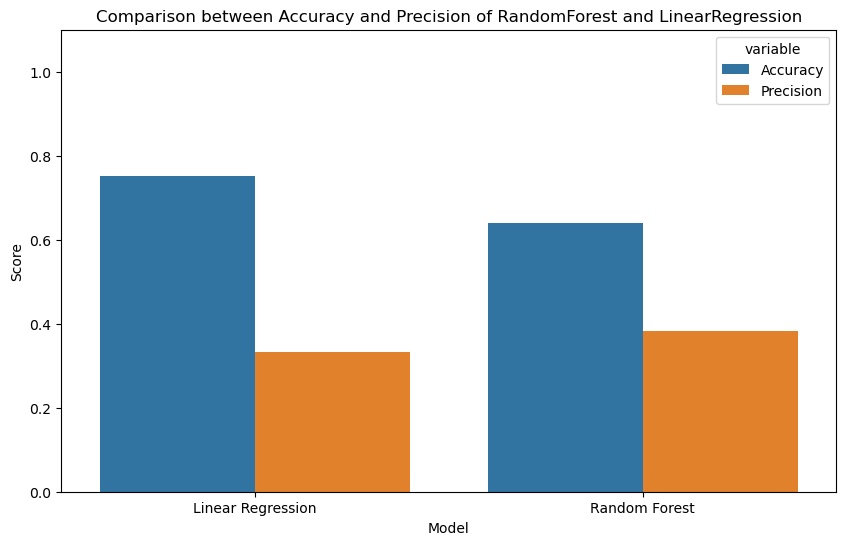

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns



# For Linear Regression:
accuracy_lin_reg = accuracy_score(test["target"], y_pred_class_lin_reg_test) # The accuracy obtained from your Linear Regression code
precision_lin_reg = precision_score(test["target"], y_pred_class_lin_reg_test) # The precision obtained from your Linear Regression code

# For Random Forest:
accuracy_rf = val_acc_entropy # The accuracy obtained from your RandomForest code
precision_rf =  precision_rf_entropy # The precision obtained from your RandomForest code

# Preparing data for plotting
models = ['Linear Regression', 'Random Forest']
accuracy = [accuracy_lin_reg, accuracy_rf]
precision = [precision_lin_reg, precision_rf]

df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracy,
    'Precision': precision
})

# Melting DataFrame for easier plotting with seaborn
df_melted = pd.melt(df, id_vars=['Model'], value_vars=['Accuracy', 'Precision'])

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='value', hue='variable', data=df_melted)
plt.title('Comparison between Accuracy and Precision of RandomForest and LinearRegression')
plt.ylabel('Score')
plt.ylim(0, 1.1)  # Assuming scores are between 0 and 1. Adjust if necessary.
plt.show()
